In [41]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pymysql
from datetime import timedelta

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

from tqdm import tqdm

In [99]:
import pydata_google_auth

SCOPES = [
  'https://www.googleapis.com/auth/cloud-platform',
  'https://www.googleapis.com/auth/drive',
  'https://www.googleapis.com/auth/bigquery'
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES, auth_local_webserver=True)

query = '''
select visitId,
    max(case h.eCommerceAction.action_type when '6' then 1 else 0 end) as converted
from `bigquery-public-data.google_analytics_sample.ga_sessions_*` 
    LEFT JOIN UNNEST(hits) as h
where parse_date('%Y%m%d', _TABLE_SUFFIX) BETWEEN DATE('2016-08-01') AND DATE('2017-07-31') 
    and h.eCommerceAction.action_type in ('2','6')
group by visitId
having max(case h.eCommerceAction.action_type when '2' then 1 else 0 end) > 0 
'''

df = pd.read_gbq(query=query, project_id="public-data-projects", credentials=credentials, dialect='standard')

print(df.shape)
df.head()

(123264, 2)


,visitId,converted
0,1497114180,0
1,1497085801,0
2,1497123928,0
3,1497110112,0
4,1497086813,0


In [100]:
df.reset_index(inplace = True)
df['group'] = df.apply(lambda x: 'a' if x['index']%2  else 'b', axis = 1)
df.group.value_counts()

b    61632
a    61632
Name: group, dtype: int64

In [170]:
group_a = df.loc[df.group == 'a', ['visitId', 'converted']]
group_b = df.loc[df.group == 'b', ['visitId', 'converted']]

n_a = group_a.shape[0]
n_b = group_b.shape[0]

p_a = group_a.converted.sum()/n_a
p_b = group_b.converted.sum()/n_b

uplift = p_b - p_a

me = z*df.converted.std()/np.sqrt(n_a + n_b)

ci = [uplift-me, uplift+me]

stat_sig = (uplift <= ci[0]) | (uplift >= ci[1])
    
print(f'''
- n of a: {round(n_a,4)}
- n of b: {round(n_b,4)}
- p of a: {round(p_a,4)}
- p of b: {round(p_b,4)}
- Uplift: {round(uplift,4)}
- Confidence Interval: {round(ci[0],4)} to {round(ci[1],4)}
- stat_sig: {stat_sig}
''')


- n of a: 61632
- n of b: 61632
- p of a: 0.0765
- p of b: 0.0755
- Uplift: -0.001
- Confidence Interval: -0.0025 to 0.0004
- stat_sig: False



In [271]:
result = pd.DataFrame()
for n in tqdm(range(100,df.shape[0], 100)):
    group_a = df.iloc[:n,:].loc[df.iloc[:n,:].group == 'a', ['visitId', 'converted']]
    group_b = df.iloc[:n,:].loc[df.iloc[:n,:].group == 'b', ['visitId', 'converted']]

    n_a = group_a.shape[0]
    n_b = group_b.shape[0]

    p_a = group_a.converted.sum()/n_a
    p_b = group_b.converted.sum()/n_b

    uplift = p_b - p_a
    
    # 95%
    me = 1.96*df.iloc[:n,:].converted.std()/np.sqrt(n_a + n_b)
    ci = [uplift-me, uplift+me]
    stat_sig = (0 <= ci[0]) | (0 >= ci[1])

    result.loc[n, 'ci_low_95'] = ci[0]
    result.loc[n, 'ci_high_95'] = ci[1]
    result.loc[n, 'stat_sig_95'] = stat_sig
    
    # 99%
    me = 2.576*df.iloc[:n,:].converted.std()/np.sqrt(n_a + n_b)
    ci = [uplift-me, uplift+me]
    stat_sig = (0 <= ci[0]) | (0 >= ci[1])

    result.loc[n, 'ci_low_99'] = ci[0]
    result.loc[n, 'ci_high_99'] = ci[1]
    result.loc[n, 'stat_sig_99'] = stat_sig

100%|██████████| 1232/1232 [00:08<00:00, 150.67it/s]


<AxesSubplot:ylabel='ci_low_95'>

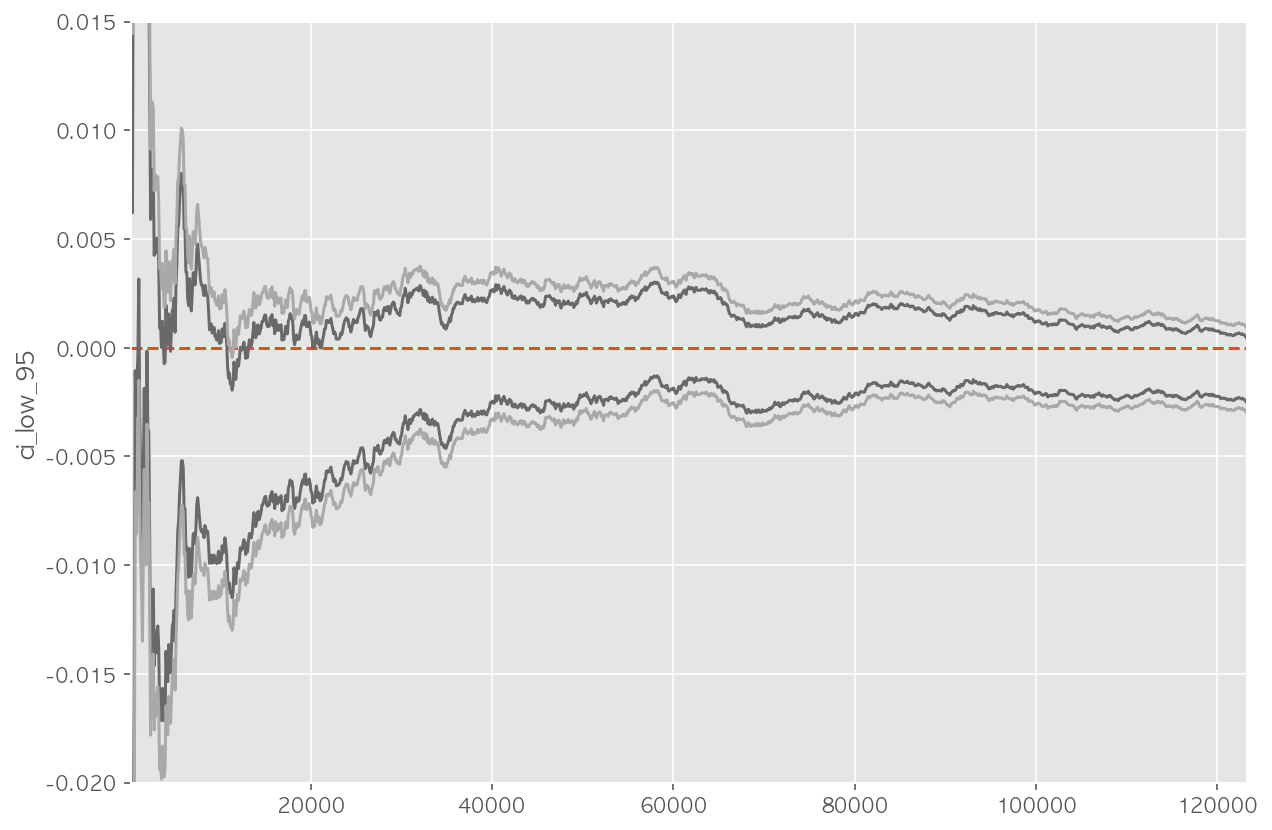

In [274]:
plt.figure(figsize = (10,7))
plt.xlim(100,df.shape[0])
plt.ylim(-0.02,0.015)
plt.axhline(0, ls = '--')
sns.lineplot(x = result.index, y = 'ci_low_95', data = result, color = 'dimgray')
sns.lineplot(x = result.index, y = 'ci_high_95', data = result, color = 'dimgray')
sns.lineplot(x = result.index, y = 'ci_low_99', data = result, color = 'darkgray')
sns.lineplot(x = result.index, y = 'ci_high_99', data = result, color = 'darkgray')


In [285]:
result[result.stat_sig_95].shape[0]

26

In [284]:
result[result.stat_sig_99].shape[0]

4